In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import re
from src.DocumentReader import read_n_documents
from src.shared import process

In [2]:
# path = 'data//arxiv-metadata-oai-snapshot.json'
# with open(path, 'r') as file:
#     records = pd.DataFrame()
#     i = 0
#     for line in file:
#         i+=1
# print(i)

In [3]:
docs = read_n_documents(0,10)
processed_documents = process(docs)
processed_documents

,title,version,abstract,authors_parsed,category_names,category_groups
0,Calculation of prompt diphoton production cros...,2007,A fully differential calculation in perturba...,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",[hep-ph],[hep-ph]
1,Sparsity-certifying Graph Decompositions,2008,"We describe a new algorithm, the $(k,\ell)$-...","[[Streinu, Ileana, ], [Theran, Louis, ]]","[math.CO, cs.CG]","[math, cs]"
2,The evolution of the Earth-Moon system based o...,2008,The evolution of Earth-Moon system is descri...,"[[Pan, Hongjun, ]]",[physics.gen-ph],[physics]
3,A determinant of Stirling cycle numbers counts...,2007,We show that a determinant of Stirling cycle...,"[[Callan, David, ]]",[math.CO],[math]
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,2007,In this paper we show how to compute the $\L...,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]","[math.CA, math.FA]","[math, math]"
5,Bosonic characters of atomic Cooper pairs acro...,2007,We study the two-particle wave function of p...,"[[Pong, Y. H., ], [Law, C. K., ]]",[cond-mat.mes-hall],[cond-mat]
6,Polymer Quantum Mechanics and its Continuum Limit,2007,A rather non-standard quantum representation...,"[[Corichi, Alejandro, ], [Vukasinac, Tatjana, ...",[gr-qc],[gr-qc]
7,Numerical solution of shock and ramp compressi...,2008,A general formulation was developed to repre...,"[[Swift, Damian C., ]]",[cond-mat.mtrl-sci],[cond-mat]
8,"The Spitzer c2d Survey of Large, Nearby, Inste...",2007,We discuss the results from the combined IRA...,"[[Harvey, Paul, ], [Merin, Bruno, ], [Huard, T...",[astro-ph],[astro-ph]
9,"Partial cubes: structures, characterizations, ...",2007,Partial cubes are isometric subgraphs of hyp...,"[[Ovchinnikov, Sergei, ]]",[math.CO],[math]


##### Map Categories like ["Physics", "Maths"] to indexes like [0,1]

In [185]:
def map_categories_to_indexes(categories):
    unique_categories = []
    all_indexes = []
    for i in categories:
        document_indexes = []
        for category in i:
            if category not in unique_categories:
                unique_categories.append(category)
                document_indexes.append(len(unique_categories)-1)
            else:
                if unique_categories.index(category) not in document_indexes:
                    document_indexes.append(unique_categories.index(category))
        all_indexes.append(document_indexes)
    return all_indexes, unique_categories


In [186]:
all_indexes, labels = map_categories_to_indexes(processed_documents['category_groups'].values)
# print(all_indexes)

##### Map indexes like [[0,1],[1,2]] to [[1,1,0],[0,1,1]]

In [187]:
from sklearn.preprocessing import MultiLabelBinarizer
import scipy.sparse as sp
mlb = MultiLabelBinarizer()

# y = sp.csr_array(mlb.fit_transform(all_indexes))
y = mlb.fit_transform(all_indexes)

In [188]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [189]:
y.shape

(100, 16)

In [190]:
labels

['hep-ph',
 'math',
 'cs',
 'physics',
 'cond-mat',
 'gr-qc',
 'astro-ph',
 'hep-th',
 'hep-ex',
 'nlin',
 'q-bio',
 'quant-ph',
 'hep-lat',
 'nucl-th',
 'math-ph',
 'nucl-ex']

<BarContainer object of 16 artists>

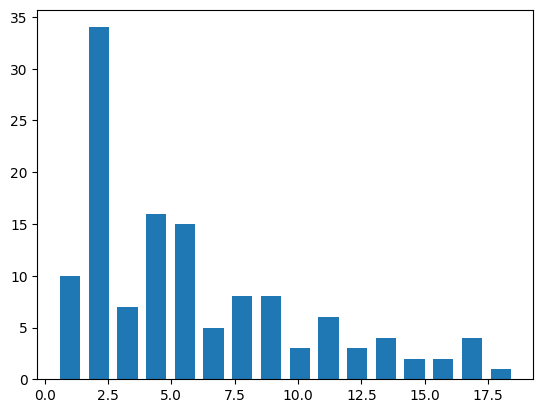

In [191]:
label_counts = y.sum(axis=0)
plt.bar(np.linspace(1,18,len(label_counts)), label_counts)

In [192]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

#What does the regular expression r'w{1,} do?
count_vect = CountVectorizer(analyzer='word')
# count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

#"fit" is actually building the vocabulary
count_vect.fit(processed_documents['abstract'].values)

#the transformation converts the text to bag-of-words
X = count_vect.transform(processed_documents['abstract'].values)  #these are sparse BOW matrices for Q1

##### Class counts

### Split data into training and test sets

In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle = True, random_state = 42)

In [194]:
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(100, 16)
(70, 16)
(30, 16)


In [195]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

tree_model = DecisionTreeClassifier()
multilabel_model = MultiOutputClassifier(tree_model).fit(X_train,y_train)
predictions = multilabel_model.predict(X_test)

In [196]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

f1_score(predictions, y_test, average="macro")

c:\Users\staso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.15865384615384615

In [197]:
f1_score(predictions[:,0], y_test[:,0], average="macro")


0.6296296296296297

In [198]:
scores = []
print("F1 scores for each category")
print()
for i in range(y_test.shape[1]):
    score = f1_score(predictions[:,i], y_test[:,i], average="macro")
    score = round(score,2)*100
    print(labels[i]+":", int(score), "% with count:", label_counts[i])
    scores.append(score)

F1 scores for each category

hep-ph: 63 % with count: 10
math: 59 % with count: 34
cs: 49 % with count: 7
physics: 43 % with count: 16
cond-mat: 71 % with count: 15
gr-qc: 49 % with count: 5
astro-ph: 48 % with count: 8
hep-th: 48 % with count: 8
hep-ex: 100 % with count: 3
nlin: 82 % with count: 6
q-bio: 49 % with count: 3
quant-ph: 73 % with count: 4
hep-lat: 100 % with count: 2
nucl-th: 49 % with count: 2
math-ph: 47 % with count: 4
nucl-ex: 100 % with count: 1


In [206]:
print("Weighted F1-scores",np.average(np.array(scores), weights=label_counts))
print("Macro F1-scores", np.average(np.array(scores)))

Weighted F1-scores 59.078125
Macro F1-scores 64.375


In [200]:
scores

[63.0,
 59.0,
 49.0,
 43.0,
 71.0,
 49.0,
 48.0,
 48.0,
 100.0,
 82.0,
 49.0,
 73.0,
 100.0,
 49.0,
 47.0,
 100.0]

In [201]:
print(label_counts)

[10 34  7 16 15  5  8  8  3  6  3  4  2  2  4  1]


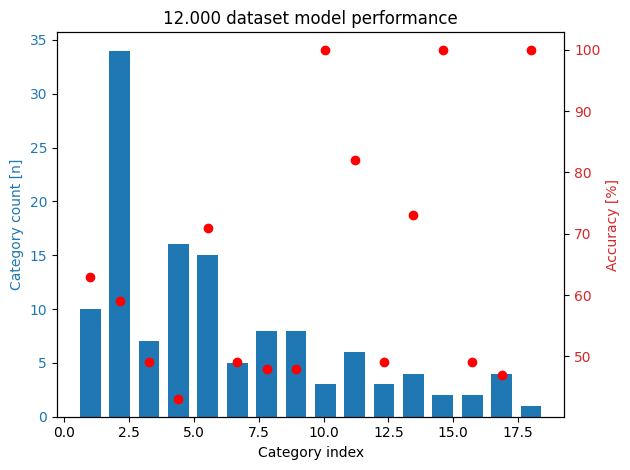

In [202]:
fig, ax1 = plt.subplots()

ax1.set_title("12.000 dataset model performance")
color = 'tab:blue'
ax1.set_xlabel('Category index')
ax1.set_ylabel('Category count [n]', color=color)
ax1.bar(np.linspace(1,18,len(label_counts)), label_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Accuracy [%]', color=color)  # we already handled the x-label with ax1
ax2.scatter(np.linspace(1,18,len(label_counts)), scores, c="red")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
